In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

[[2.131162   0.77615233]
 [0.26210633 1.59153164]
 [0.91521467 1.8463624 ]
 ...
 [4.02274413 2.0638402 ]
 [3.49669859 4.65635086]
 [2.13947051 4.13785801]]


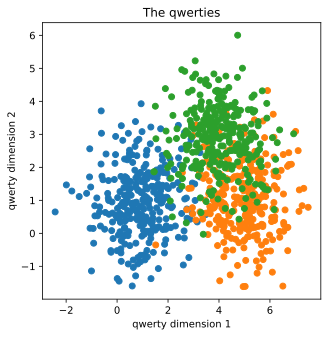

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur] 
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur] 
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]
# true labels 
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1)),np.full((nPerClust,1),2)))

#convert to a pytorch tensor
data_np = np.hstack((a,b,c)).T

print(data_np)

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize = (5,5))
plt.scatter(data[np.where(labels==0)[0], 0], data[np.where(labels == 0)[0], 1])
plt.scatter(data[np.where(labels==1)[0], 0], data[np.where(labels == 1)[0], 1])
plt.scatter(data[np.where(labels==2)[0], 0], data[np.where(labels == 2)[0], 1])

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2)

# then convert them into pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last= True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [4]:
# create a class for the model 
def createTheQwertyNet(l2):
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer 
            self.input = nn.Linear(2,8)

            # hiddent layer 
            self.fc1 = nn.Linear(8,8)

            # output layer
            self.output = nn.Linear(8,3)

        def forward(self, X):
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            return self.output(X)
        
    # create the model instance 
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, weight_decay = l2)

    return net, lossfun, optimizer

In [5]:
numepochs = 50

def function2trainTheModel(l2):
    # create a new model
    net, lossfun , optimizer = createTheQwertyNet(l2)
    

    # initialize losses 
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        net.train()

        # looping over training batches 
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss 
            yHat = net(X)
            loss = lossfun(yHat, y)

            # BACKPROP 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy

            matches = torch.argmax(yHat, axis = 1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)

        testAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
    
    return trainAcc, testAcc, losses , net

In [16]:
l2rates = np.linspace(0, 0.1, 6)
performanceTrain = np.zeros((numepochs, len(l2rates)))
performanceTest = np.zeros((numepochs, len(l2rates)))

for index, l2 in enumerate(l2rates):
    trainAcc, testAcc, losses, net = function2trainTheModel(l2)
    performanceTrain[:, index] = trainAcc
    performanceTest[:, index] = testAcc

    



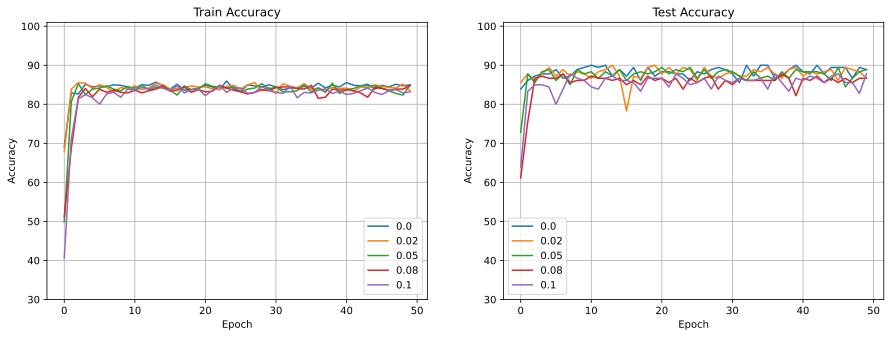

In [18]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(performanceTrain, label = l2rates)
ax[0].set_title('Train Accuracy')
ax[1].plot(performanceTest, label = l2rates)
ax[1].set_title('Test Accuracy')
leglabels = [np.round(i,2) for i in l2rates]

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim([30,101])
    ax[i].grid()
plt.show()




plt.show()